# load models

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
from fastai.text import *

In [ ]:
wiki_path = "../data/wiki/"
wiki = load_learner(wiki_path, "wiki-heb.pkl")

## load the data

In [13]:
import codecs
import pandas as pd

In [14]:
data_frame = {}
for i in ["train", "test"]:
    data = list(codecs.open("token_{}.tsv".format(i), 'r', 'utf-8').readlines())
    x, y = zip(*[d.strip().split('\t') for d in data])
    data_frame[i] = pd.DataFrame({"text": x, "label": y, "valid": i=="valid"})

msk = np.random.rand(len(data_frame["train"])) < 0.8
train = data_frame["train"][msk]
valid = data_frame["train"][~msk]
len(train), len(valid), len(data_frame["test"])

(8283, 1961, 2560)

In [15]:
dataframe = pd.concat([data_frame["train"], data_frame["test"]])

## language model

In [6]:
data_lm = (TextList.from_df(dataframe, cols=["text"])
            .random_split_by_pct(0.2)
            .label_for_lm()           
            .databunch(bs=24))

In [7]:
learn = language_model_learner(data_lm, AWD_LSTM,pretrained=wiki, drop_mult=0.3)
learn.fit_one_cycle(5, 5e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,6.220709,5.484374,0.215045,00:18
2,5.553494,5.170030,0.230997,00:18
3,5.061144,4.885295,0.248705,00:18
4,4.338058,4.565722,0.272887,00:18
5,3.791138,4.486769,0.280595,00:19


In [8]:
learn.unfreeze()
learn.fit_one_cycle(4, slice(1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,3.592474,4.479295,0.281265,00:23
2,3.487288,4.421715,0.287813,00:24
3,3.404001,4.394275,0.291756,00:24
4,3.321803,4.392702,0.292158,00:24


In [9]:
learn.save_encoder("encoder_with_wiki")

## classification

In [10]:
data_clas = TextClasDataBunch.from_df("",vocab=learn.data.vocab, train_df=train, valid_df=valid, test_df=data_frame["test"],
                                      text_cols=["text"], label_cols=["label"], bs=24)
learn_class = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn_class.load_encoder("encoder_with_wiki")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


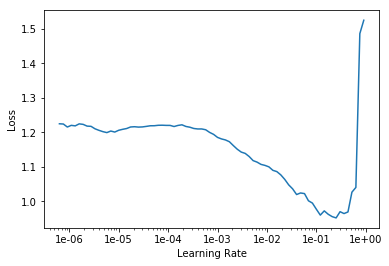

In [60]:
learn_class.lr_find()
learn_class.recorder.plot()

In [11]:
learn_class.fit_one_cycle(3, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,0.645144,0.528946,0.784601,00:19
2,0.648825,0.512086,0.774209,00:20
3,0.630393,0.474072,0.791686,00:21


In [12]:
learn_class.freeze_to(-2)
learn_class.fit_one_cycle(4, slice(1e-3,1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,0.605204,0.481102,0.785073,00:22
2,0.544602,0.442631,0.822863,00:23
3,0.546218,0.410792,0.834672,00:24
4,0.511480,0.411738,0.837978,00:23


In [13]:
learn_class.save("stap_1133")

In [14]:
learn_class.freeze_to(-3)
learn_class.fit_one_cycle(5, slice(1e-4,1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,0.486842,0.413254,0.838923,00:34
2,0.502877,0.387132,0.842230,00:34
3,0.490464,0.392324,0.841285,00:36
4,0.492177,0.368119,0.844591,00:34
5,0.474288,0.380131,0.840340,00:34


In [16]:
learn_class.unfreeze()
learn_class.fit_one_cycle(10, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,0.480481,0.366045,0.844591,00:44
2,0.471634,0.362521,0.851205,00:45
3,0.480540,0.362567,0.854039,00:44
4,0.482509,0.356855,0.853566,00:43
5,0.447744,0.351234,0.848843,00:44
6,0.457481,0.345601,0.854511,00:42
7,0.438475,0.357253,0.854511,00:42
8,0.415781,0.347016,0.858290,00:42
9,0.421279,0.347228,0.851205,00:44
10,0.421014,0.343618,0.859235,00:46


In [34]:
# learn_class.load("stap_1133")

In [35]:
learn_class.fit_one_cycle(10, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,0.430445,0.352263,0.851677,00:42
2,0.420332,0.343226,0.858762,00:45
3,0.416025,0.342263,0.860179,00:48
4,0.412862,0.340309,0.866320,00:46
5,0.404726,0.342247,0.872933,00:46
6,0.393662,0.331258,0.870099,00:46
7,0.376308,0.332787,0.868682,00:46
8,0.349412,0.323521,0.871044,00:46
9,0.397847,0.333159,0.869627,00:43
10,0.363470,0.328157,0.870572,00:46


In [36]:
learn_class.fit_one_cycle(10, slice(5e-5,5e-4), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,0.368252,0.327168,0.875295,00:46
2,0.367052,0.321825,0.873878,00:46
3,0.362950,0.325290,0.880019,00:45
4,0.350644,0.316258,0.879547,00:44
5,0.336167,0.295556,0.886632,00:42
6,0.357476,0.313255,0.883325,00:44
7,0.377259,0.293701,0.885687,00:45
8,0.334631,0.296438,0.888521,00:45
9,0.319901,0.299453,0.887577,00:42
10,0.332896,0.304719,0.888521,00:46


In [38]:
learn_class.fit_one_cycle(20, slice(1e-5,1e-4), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,0.297049,0.295260,0.890883,00:46
2,0.301593,0.286685,0.892773,00:45
3,0.294316,0.297580,0.894662,00:47
4,0.309265,0.286255,0.891828,00:44
5,0.288416,0.286141,0.894662,00:46
6,0.347343,0.309444,0.894662,00:46
7,0.291492,0.286182,0.896079,00:43
8,0.311777,0.309300,0.894190,00:44
9,0.277730,0.285690,0.888521,00:47
10,0.281129,0.288903,0.896079,00:44


In [41]:
learn_class.fit_one_cycle(20, slice(3e-5,3e-4), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,0.284318,0.281651,0.898441,00:47
2,0.314541,0.279433,0.897496,00:41
3,0.284289,0.281128,0.899858,00:44
4,0.291274,0.289481,0.896079,00:45
5,0.295475,0.287604,0.900803,00:44
6,0.266569,0.295764,0.897496,00:45
7,0.314759,0.284094,0.898914,00:47
8,0.278546,0.286727,0.902692,00:44
9,0.245888,0.280406,0.901275,00:43
10,0.239450,0.273197,0.897024,00:44


In [46]:
learn_class.fit_one_cycle(20, slice(1e-4,1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,0.241065,0.283066,0.905999,00:44
2,0.263610,0.273690,0.908833,00:43
3,0.234747,0.266632,0.906471,00:44
4,0.291378,0.277073,0.903637,00:43
5,0.262144,0.283058,0.909306,00:44
6,0.233142,0.277939,0.906471,00:42
7,0.257002,0.302926,0.908833,00:44
8,0.220759,0.280881,0.916391,00:45
9,0.205767,0.283635,0.915446,00:46
10,0.225105,0.288741,0.914029,00:46


In [49]:
p = learn_class.get_preds(ds_type = DatasetType.Test, ordered=True)
results = list(map(int, data_frame["test"]["label"].values)) == np.argmax(p[0].numpy(), axis=1)
results.sum() / len(p[1])

0.908984375

In [47]:
learn_class.save("stap_1133")

In [48]:
learn.export("rivlin_final.pkl")
data_clas.save("final_data")

In [3]:
learn = load_learner("","rivlin_final.pkl")
data_clas = load_data("", "final_data", bs=24)

In [4]:
learn_class = text_classifier_learner(data_clas, AWD_LSTM, pretrained=learn, drop_mult=0.5)
# learn_class = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)

In [5]:
learn_class.unfreeze()

In [32]:
learn_class.fit_one_cycle(5, slice(1e-4,1e-3), moms=(0.6,0.5))

epoch,train_loss,valid_loss,accuracy,time
1,0.162962,0.305781,0.914502,00:45
2,0.145874,0.273591,0.917336,00:43
3,0.146820,0.283173,0.923477,00:45
4,0.151858,0.273747,0.914502,00:45
5,0.138720,0.281516,0.920642,00:44


In [35]:
learn_class.fit_one_cycle(5, slice(3e-5,3e-4), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,0.143467,0.277645,0.920170,00:40
2,0.126571,0.286871,0.920170,00:43
3,0.127284,0.295493,0.918753,00:45
4,0.127542,0.276836,0.921115,00:42
5,0.148976,0.285736,0.922060,00:41


In [149]:
learn_class.fit_one_cycle(5, slice(1e-5,1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,0.129210,0.296262,0.922060,00:44
2,0.119033,0.292667,0.916391,00:44
3,0.158399,0.271702,0.915919,00:43
4,0.144393,0.296420,0.923477,00:45
5,0.113472,0.291274,0.923477,00:43


In [171]:
# learn_class.load("stap_1133")

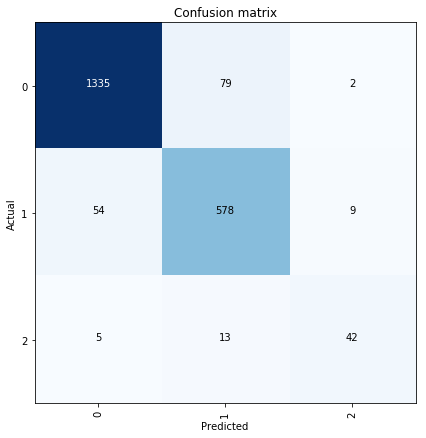

In [150]:
interp = ClassificationInterpretation.from_learner(learn_class, ds_type=DatasetType.Valid)
interp.plot_confusion_matrix(figsize=(6,6))

In [172]:
p = learn_class.get_preds(ds_type = DatasetType.Test, ordered=True)
results = list(map(int, data_frame["test"]["label"].values)) == np.argmax(p[0].numpy(), axis=1)
results.sum() / len(p[1])

0.915625